<div align="center">

# <span style="font-size: 2em;">Label Propagation!</span>

</div>

<p align="center">
  <img src="Label.png" alt="Header" />
</p>

<div align="center">

# <span style="font-size: em;">Semi-supervised!</span>

</div>

# Graph Algorithms and Community Detection

This project explores **graph theory algorithms**, focusing on community detection, zero-weight edge behavior, and label propagation using synthetic and real-world networks.

It includes:
 Graph definitions and theory  
 Dominating sets  
 Community detection  
 Label propagation with convergence tracking  
 Tests for how key algorithms handle zero-weight edges  
 Output CSVs for comparison and benchmarking

---

## What Is a Graph?

A **graph** is a mathematical structure made up of:
- **Nodes (vertices)** → individual entities (people, cities, routers, etc.)
- **Edges (links)** → relationships or connections between nodes

Graphs can be:
- **Undirected** → connections go both ways (friendships)
- **Directed** → connections have a direction (Twitter follows, hyperlinks)
- **Weighted** → edges have numeric values (distance, strength, cost)

---

## What Is a Dominating Set?

A **dominating set** is a subset of nodes such that **every node in the graph is either in the set or directly connected to a node in the set**.

Formally, for a graph $G = (V, E)$, a set $D \subseteq V$ is a dominating set if every node $v \in V$ is either in $D$ or adjacent to at least one node in $D$.

**Why is it useful?**
- Network monitoring (place sensors at minimum key points)
- Social influence (select influencers to spread information)
- Facility placement (locate service hubs to cover all customers)

---

##  What Is Community Detection?

**Community detection** finds groups of nodes (communities) that are more densely connected internally than to the rest of the graph.

Examples:
- Social networks → friend groups
- Biology → functional protein modules
- Marketing → customer segments

**Why does it work?**
- Real-world networks often show **modularity** → nodes naturally cluster into tight groups.
- Algorithms like Louvain maximize **modularity score** to find these clusters.

---

## Included Algorithms and Tests

| File                          | Purpose                                                             |
|-------------------------------|---------------------------------------------------------------------|
| `label_propagation.py`        | Runs label propagation, tracks label history, and plots convergence |
| `zero_weight_tests.py`        | Tests Louvain, PageRank, betweenness, eigenvector, Dijkstra, cosine similarity on zero-weight edge graphs |
| `synthetic_network.py`        | Creates and visualizes synthetic social networks with random cross-cluster edges |
| `community_convergence.csv`   | (Generated) CSV recording community sizes over label propagation iterations |
| `zero_weight_behavior_comparison.csv` | (Generated) CSV comparing algorithm behavior on zero-weight test graphs |

---

##  Requires

1. Install dependencies:
```bash
pip install networkx numpy pandas scipy matplotlib python-louvain


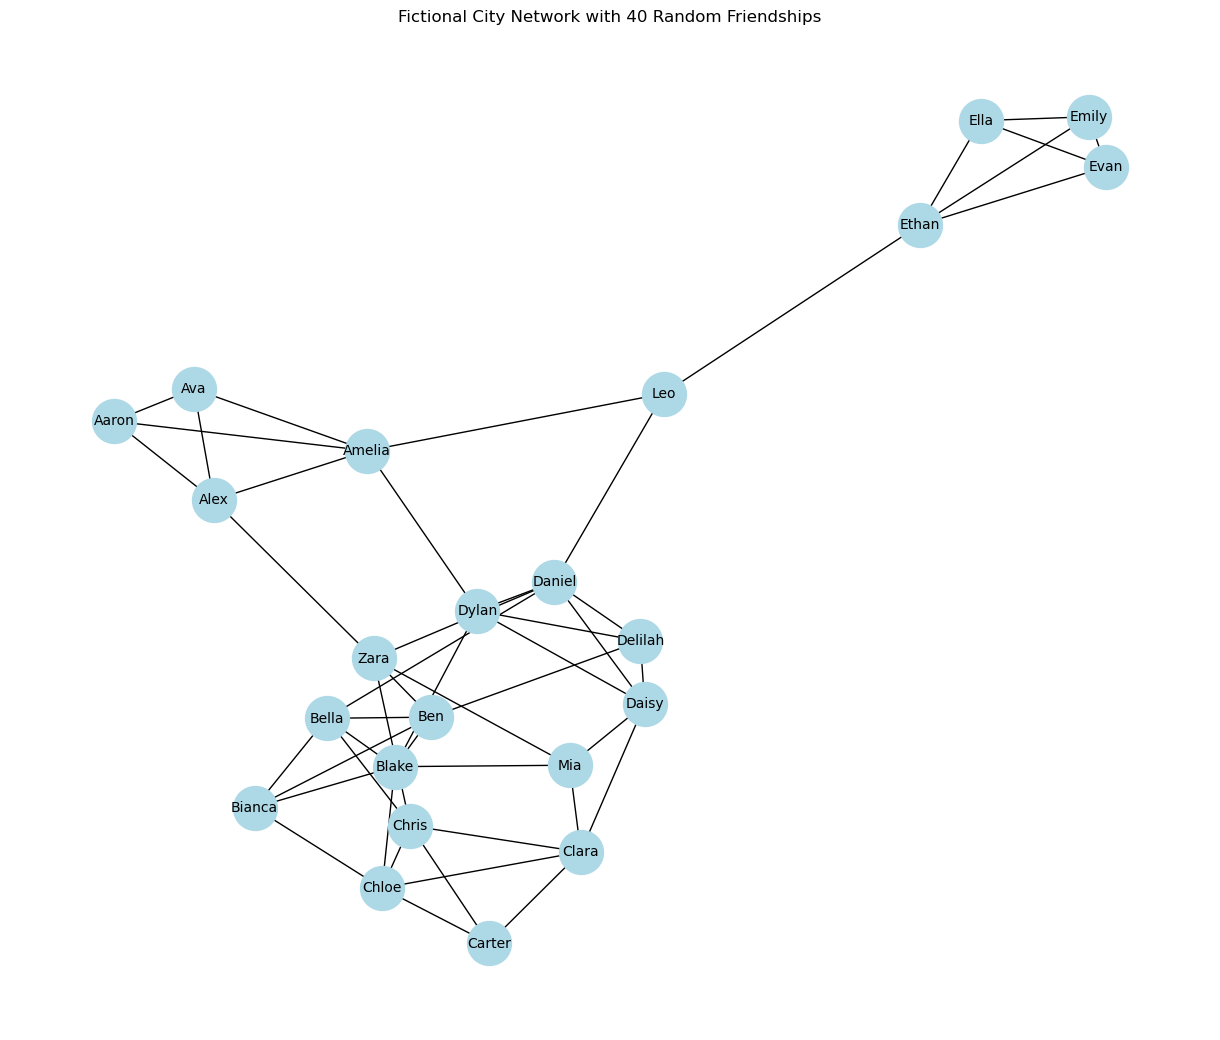

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import random


G = nx.Graph()

# Define clusters (cities)
city_a = ['Alex', 'Ava', 'Aaron', 'Amelia']
city_b = ['Ben', 'Bella', 'Blake', 'Bianca']
city_c = ['Chris', 'Chloe', 'Carter', 'Clara']
city_d = ['Daniel', 'Daisy', 'Dylan', 'Delilah']
city_e = ['Ethan', 'Ella', 'Evan', 'Emily']

# Fully connect inside each city
G.add_edges_from([(u, v) for u in city_a for v in city_a if u != v])
G.add_edges_from([(u, v) for u in city_b for v in city_b if u != v])
G.add_edges_from([(u, v) for u in city_c for v in city_c if u != v])
G.add_edges_from([(u, v) for u in city_d for v in city_d if u != v])
G.add_edges_from([(u, v) for u in city_e for v in city_e if u != v])

# Add fixed connectors between cities (travelers)
G.add_edges_from([
    ('Zara', 'Alex'), ('Zara', 'Ben'), ('Zara', 'Chris'),
    ('Leo', 'Daniel'), ('Leo', 'Ethan'), ('Leo', 'Amelia'),
    ('Mia', 'Clara'), ('Mia', 'Daisy'), ('Mia', 'Blake'),
])

# Function to add random cross-cluster edges
def add_random_edges(G, num_edges):
    all_nodes = list(G.nodes)
    added = 0
    while added < num_edges:
        u, v = random.sample(all_nodes, 2)
        if not G.has_edge(u, v):
            G.add_edge(u, v)
            added += 1

# Only add 40 random edges and plot
G_copy = G.copy()
add_random_edges(G_copy, 10)

pos = nx.spring_layout(G_copy, seed=42)
plt.figure(figsize=(12, 10))
nx.draw(G_copy, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=10)
plt.title("Fictional City Network with 40 Random Friendships")
plt.show()


In [37]:
for neighbor in nx.neighbors(G, 'Bella'):
    print(neighbor)

Ben
Blake
Bianca


### Label Propagation Algorithm

This code implements the **Label Propagation Algorithm (LPA)** to detect communities (clusters) in a network graph `G` using only local neighbor information.

Here’s a summary of what happens:

1. **Initialization**
   - Each node in the graph is assigned a **unique label**, typically its own node ID.
   - This means every node starts as its own “community.”

2. **Iterative label updates**
   - For up to `max_iter` iterations:
     - The node order is **randomly shuffled** to avoid update bias.
     - For each node:
       - It looks at the **labels of its immediate neighbors.**
       - It finds the **most common label** among those neighbors.
       - If the node’s current label **differs** from this majority label, it **updates its label** to match.
     - A flag `changed` tracks whether any label updates happened during the iteration.

3. **Convergence check**
   - If during any iteration **no labels were updated** (`changed = False`), the algorithm considers the system to have **converged** and stops early.
   - Otherwise, it continues until the maximum number of iterations is reached.
   - We can show the convergence in a graph as shown. 

4. **Output**
   - The function returns a dictionary `labels` that maps each node to its final community label.
   - Nodes with the same label at the end belong to the same detected community.

###  Why this works
The algorithm works by letting labels “compete” across the network. Over multiple rounds, popular labels spread across neighborhoods, and eventually **large, stable regions of nodes share the same label**, effectively revealing the network’s community structure.

In [38]:
def label_propagation_with_history(G, max_iter=100):
    labels = {node: node for node in G.nodes()}
    history = []  # store labels at each iteration

    for iteration in range(max_iter):
        changed = False
        nodes = list(G.nodes())
        random.shuffle(nodes)

        for node in nodes:
            neighbor_labels = [labels[neighbor] for neighbor in G.neighbors(node)]
            if neighbor_labels:
                most_common_label, _ = Counter(neighbor_labels).most_common(1)[0]
                if labels[node] != most_common_label:
                    labels[node] = most_common_label
                    changed = True

        # Store a copy of the current labels
        history.append(labels.copy())

        if not changed:
            print(f"Converged after {iteration+1} iterations.")
            break

    return labels, history


Converged after 3 iterations.


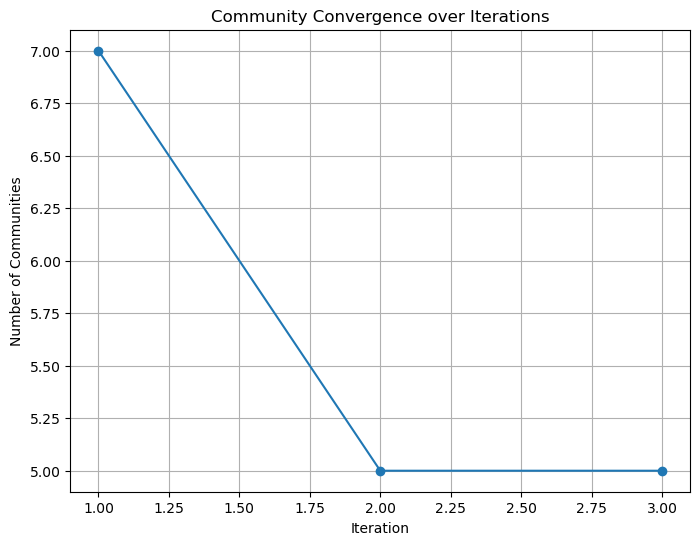

In [39]:
final_labels, label_history = label_propagation_with_history(G)
import matplotlib.pyplot as plt

num_communities = [len(set(labels.values())) for labels in label_history]

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(num_communities)+1), num_communities, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Number of Communities')
plt.title('Community Convergence over Iterations')
plt.grid(True)
plt.show()


### Grouping and Displaying Detected Communities

After running the `label_propagation` function, we get a dictionary `final_labels` that maps each node to its detected community label.

The following code organizes and prints the communities:

```python
from collections import defaultdict

# Group nodes by labels
communities = defaultdict(list)
for node, label in final_labels.items():
    communities[label].append(node)

print("Detected Communities:")
for idx, community in enumerate(communities.values(), 1):
    print(f"Community {idx}: {community}")


In [40]:
from collections import defaultdict

# Group nodes by labels
communities = defaultdict(list)
for node, label in final_labels.items():
    communities[label].append(node)

print("Detected Communities:")
for idx, community in enumerate(communities.values(), 1):
    print(f"Community {idx}: {community}")

Detected Communities:
Community 1: ['Alex', 'Ava', 'Aaron', 'Amelia', 'Zara']
Community 2: ['Ben', 'Bella', 'Blake', 'Bianca']
Community 3: ['Chris', 'Chloe', 'Carter', 'Clara', 'Mia']
Community 4: ['Daniel', 'Daisy', 'Dylan', 'Delilah', 'Leo']
Community 5: ['Ethan', 'Ella', 'Evan', 'Emily']


### Visualizing Detected Communities

After grouping nodes into communities, this code assigns colors to each community and plots the graph:

```python
color_map = ['lightblue', 'lightgreen', 'lightpink', 'orange', 'yellow', 'violet', 'cyan']
node_colors = {}
for idx, community in enumerate(communities.values()):
    for node in community:
        node_colors[node] = color_map[idx % len(color_map)]

# Plot clearly labeled communities
plt.figure(figsize=(10,8))
nx.draw(G, pos, with_labels=True,
        node_color=[node_colors[node] for node in G.nodes()],
        node_size=1000, font_size=10)
plt.title("Detected Communities (After Label Propagation)")
plt.show()


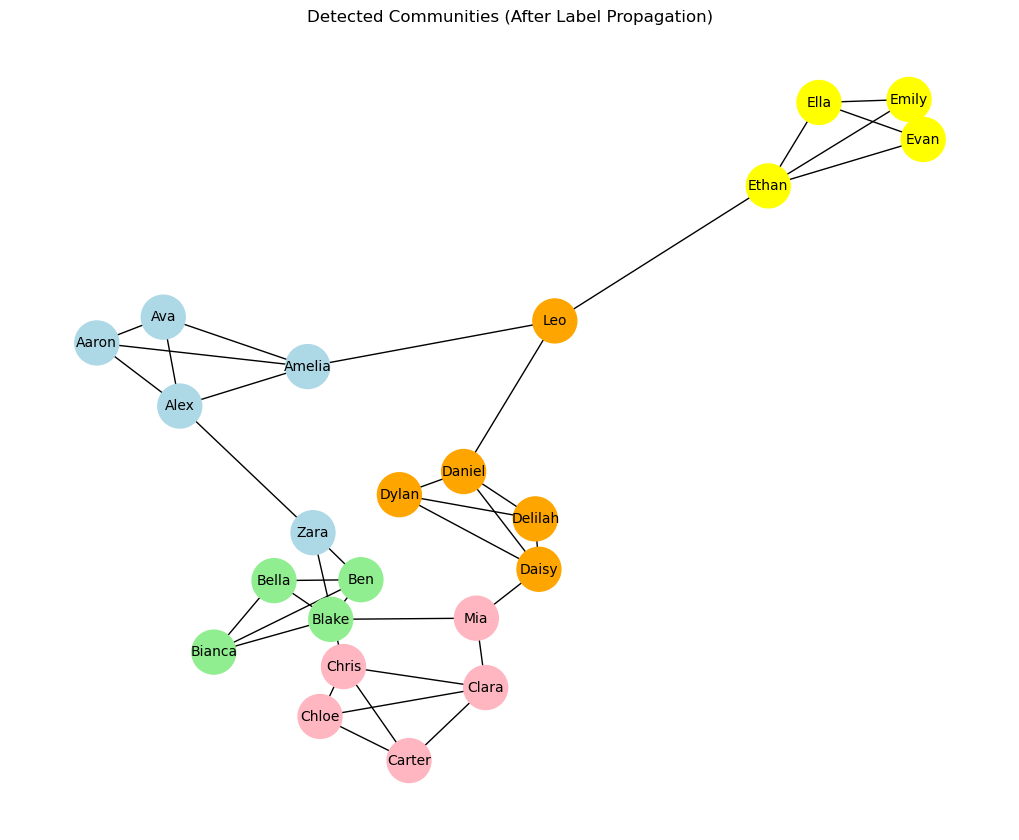

In [41]:
color_map = ['lightblue', 'lightgreen', 'lightpink', 'orange', 'yellow', 'violet', 'cyan']
node_colors = {}
for idx, community in enumerate(communities.values()):
    for node in community:
        node_colors[node] = color_map[idx % len(color_map)]

# Plot clearly labeled communities
plt.figure(figsize=(10,8))
nx.draw(G, pos, with_labels=True,
        node_color=[node_colors[node] for node in G.nodes()],
        node_size=1000, font_size=10)
plt.title("Detected Communities (After Label Propagation)")
plt.show()


# Zero-Weight Edge Behavior in Network Algorithms

This module explores how key graph algorithms behave when processing networks containing **zero-weight edges**.  
Zero-weight edges can cause nontrivial behaviors, such as ignoring paths or dominating calculations, depending on the algorithm.

---

## Requirements

- `networkx` → graph creation + algorithms  
- `numpy` → numerical operations  
- `pandas` → result table + CSV export  
- `scipy` → cosine similarity  
- *(optional)* `python-louvain` → Louvain community detection

---

## Overview of Algorithms Tested

| Algorithm                 | Purpose                                          | Reference                                      |
|--------------------------|--------------------------------------------------|------------------------------------------------|
| **Louvain**             | Community detection via modularity maximization   | Blondel et al. (2008), https://doi.org/10.1088/1742-5468/2008/10/P10008 |
| **PageRank**            | Node importance via random walk with restart      | Page et al. (1999), https://ilpubs.stanford.edu/422/ |
| **Betweenness Centrality** | Node importance via shortest paths            | Freeman (1977), https://doi.org/10.2307/3033543 |
| **Eigenvector Centrality** | Influence based on connections to influential nodes | Bonacich (1972), https://doi.org/10.2307/2786540 |
| **Cosine Similarity**    | Pairwise similarity of edge weight vectors       | Salton & McGill (1983), Introduction to Modern Information Retrieval |
| **Dijkstra’s Algorithm**| Shortest path calculation with edge weights      | Dijkstra (1959), https://doi.org/10.1007/BF01386390 |

---

## What This section Does

1. **Graph Construction**  
   Small graphs with both regular and zero-weight edges are created to challenge each algorithm.

2. **Algorithm Evaluation**  
   For each algorithm:
   - The test is run on the custom graph
   - The behavior with zero-weight edges is captured

3. **Result Logging**  
   Results are assembled into a Pandas DataFrame with:
   - `Algorithm` → the algorithm tested  
   - `NetworkX Result` → direct output from NetworkX  
   - `Product Result` → placeholder for external system comparison  
   - `Same/Different` → placeholder to record whether results match  
   - `Notes` → placeholder for observations or anomalies

4. **CSV Export**  


In [42]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

# Louvain support
try:
    import community as community_louvain
    louvain_installed = True
except ImportError:
    louvain_installed = False
    print("Warning: 'python-louvain' package not installed. Louvain test will be skipped.")

# Initialize a list to collect results
results = []

# --------------- Test functions ----------------

def test_louvain_zero_weight():
    G = nx.Graph()
    G.add_edge(1, 2, weight=1.0)
    G.add_edge(2, 3, weight=1.0)
    G.add_edge(3, 4, weight=0.0)  # Zero-weight edge
    G.add_edge(4, 5, weight=1.0)
    partition = community_louvain.best_partition(G, weight='weight')
    return partition

def test_pagerank_zero_weight():
    G = nx.DiGraph()
    G.add_edge(1, 2, weight=1.0)
    G.add_edge(2, 3, weight=0.0)
    G.add_edge(3, 1, weight=1.0)
    pr = nx.pagerank(G, weight='weight')
    return pr

def test_betweenness_zero_weight():
    G = nx.Graph()
    G.add_edge(1, 2, weight=1.0)
    G.add_edge(1, 3, weight=5.0)
    G.add_edge(2, 3, weight=0.0)
    bc = nx.betweenness_centrality(G, weight='weight')
    return bc

def test_eigenvector_zero_weight():
    G = nx.Graph()
    G.add_edge(1, 2, weight=1.0)
    G.add_edge(2, 3, weight=1.0)
    G.add_edge(1, 3, weight=0.0)
    ec = nx.eigenvector_centrality(G, weight='weight')
    return ec

def test_cosine_similarity_zero_weight():
    G = nx.Graph()
    G.add_edge(1, 2, weight=1.0)
    G.add_edge(1, 3, weight=0.0)
    G.add_edge(2, 3, weight=1.0)
    vec_1 = [G[1][2]['weight'], G[1][3]['weight']]
    vec_2 = [G[2][1]['weight'], G[2][3]['weight']]
    sim = 1 - cosine(vec_1, vec_2)
    return sim

def test_dijkstra_zero_weight():
    G = nx.DiGraph()
    G.add_edge(1, 2, weight=5.0)
    G.add_edge(1, 3, weight=1.0)
    G.add_edge(3, 2, weight=0.0)
    path = nx.shortest_path(G, 1, 2, weight='weight')
    length = nx.shortest_path_length(G, 1, 2, weight='weight')
    return (path, length)

# --------------- Running Tests ----------------

def add_result(algorithm, networkx_behavior):
    results.append({
        "Algorithm": algorithm,
        "NetworkX Result": networkx_behavior,
        "Product Result": "",  
        "Same/Different": "",  
        "Notes": ""            
    })

if louvain_installed:
    partition = test_louvain_zero_weight()
    add_result("Louvain (community detection)", f"Partition: {partition}")
else:
    add_result("Louvain (community detection)", "Skipped (louvain package not installed)")

pagerank_scores = test_pagerank_zero_weight()
add_result("PageRank", f"Scores: {pagerank_scores}")

betweenness_scores = test_betweenness_zero_weight()
add_result("Betweenness Centrality", f"Scores: {betweenness_scores}")

eigenvector_scores = test_eigenvector_zero_weight()
add_result("Eigenvector Centrality", f"Scores: {eigenvector_scores}")

cosine_score = test_cosine_similarity_zero_weight()
add_result("Cosine Similarity", f"Score: {cosine_score}")

path, length = test_dijkstra_zero_weight()
add_result("Dijkstra Shortest Path", f"Path: {path}, Length: {length}")

# --------------- Exporting to CSV ----------------

df = pd.DataFrame(results)
df.to_csv("zero_weight_behavior_comparison.csv", index=False)

print("\n Results written to 'zero_weight_behavior_comparison.csv'")
print(df)



 Results written to 'zero_weight_behavior_comparison.csv'
                       Algorithm  \
0  Louvain (community detection)   
1                       PageRank   
2         Betweenness Centrality   
3         Eigenvector Centrality   
4              Cosine Similarity   
5         Dijkstra Shortest Path   

                                     NetworkX Result Product Result  \
0          Partition: {1: 1, 2: 1, 3: 1, 4: 0, 5: 0}                  
1  Scores: {1: 0.3411716203526378, 2: 0.474411616...                  
2                   Scores: {1: 0.0, 2: 1.5, 3: 0.0}                  
3  Scores: {1: 0.5000000644180599, 2: 0.707106690...                  
4                          Score: 0.7071067811865475                  
5                       Path: [1, 3, 2], Length: 1.0                  

  Same/Different Notes  
0                       
1                       
2                       
3                       
4                       
5                       


In [43]:
df

,Algorithm,NetworkX Result,Product Result,Same/Different,Notes
0,Louvain (community detection),"Partition: {1: 1, 2: 1, 3: 1, 4: 0, 5: 0}",,,
1,PageRank,"Scores: {1: 0.3411716203526378, 2: 0.474411616...",,,
2,Betweenness Centrality,"Scores: {1: 0.0, 2: 1.5, 3: 0.0}",,,
3,Eigenvector Centrality,"Scores: {1: 0.5000000644180599, 2: 0.707106690...",,,
4,Cosine Similarity,Score: 0.7071067811865475,,,
5,Dijkstra Shortest Path,"Path: [1, 3, 2], Length: 1.0",,,
